<a href="https://colab.research.google.com/github/vi21g/efficientnetv2-finetuning/blob/main/finetuning_EfficientNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе вам необходимо, используя пример из урока 19.2 и Keras 3, произвести тонкую настройку модели второй версии [EfficientNetV2](https://keras.io/api/applications/efficientnet_v2/) на примере набора данных [Stanford Dogs](https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip).

### 10 classes. augmented. val_acc, test_acc 97%

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0

print("keras.__version: ", keras.__version__)

IMAGE_SIZE = (200, 200) # Размер определен выбором модели (от 128 до 300)
BATCH_SIZE = 128

keras.__version:  3.4.1


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-10-23 11:17:27--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  20.2MB/s    in 38s     

2024-10-23 11:18:06 (19.3 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
IMAGE_PATH = './images/'  # создаем переменную для папок с картинками из датасета

!unzip -qo "stanford_dogs" -d ./images/  # unzip в папку

In [ ]:
# Фильтрация битых файлов
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь

    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
# Выбираем рандомные 10 классов
from random import sample

sample_list = sample(os.listdir(IMAGE_PATH), 10)
print(sample_list)

['Papillon', 'Basset', 'English_springer', 'Malinois', 'Curly-coated_retriever', 'Blenheim_spaniel', 'Chesapeake_Bay_retriever', 'Kelpie', 'Bouvier_des_Flandres', 'Wire-haired_fox_terrier']


In [ ]:
import shutil

# Удаляем ненужные папки
# Проходим по всем элементам в IMAGE_PATH
for folder_name in os.listdir(IMAGE_PATH):
    folder_path = os.path.join(IMAGE_PATH, folder_name)

    # Проверяем, является ли элемент каталогом и не включён ли он в sample_list
    if os.path.isdir(folder_path) and folder_name not in sample_list:
        # Удаляем каталог
        shutil.rmtree(folder_path)
        # print(f"Удалён каталог: {folder_path}")

In [ ]:
DATASET_DIR = './dataset'

In [ ]:
import os
import shutil
import random

# Создаем папки для train, test и val
os.makedirs(os.path.join(DATASET_DIR, 'train'), exist_ok=True)
os.makedirs(os.path.join(DATASET_DIR, 'test'), exist_ok=True)
os.makedirs(os.path.join(DATASET_DIR, 'val'), exist_ok=True)

# Получаем списки классов
classes = os.listdir(IMAGE_PATH)

for class_name in classes:
    class_folder = os.path.join(IMAGE_PATH, class_name)

    if os.path.isdir(class_folder):
        # Получаем список изображений в классе
        images = os.listdir(class_folder)

        # Перемешиваем изображения
        random.shuffle(images)

        # Определяем количество изображений для каждой категории
        total_images = len(images)
        num_train = int(total_images * 0.7)
        num_val = int(total_images * 0.15)

        # Выделяем подмножества для train, val, test
        train_images = images[:num_train]
        val_images = images[num_train:num_train + num_val]
        test_images = images[num_train + num_val:]

        # Создаем папки для классов в train, test и val
        os.makedirs(os.path.join(DATASET_DIR, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(DATASET_DIR, 'val', class_name), exist_ok=True)
        os.makedirs(os.path.join(DATASET_DIR, 'test', class_name), exist_ok=True)

        # Копируем изображения в соответствующие папки
        for image in train_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(DATASET_DIR, 'train', class_name, image))

        for image in val_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(DATASET_DIR, 'val', class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(DATASET_DIR, 'test', class_name, image))


def count_files_in_directory(directory):
    total_files = 0

    # Проходим по всем директориям и поддиректориям
    for dirpath, dirnames, filenames in os.walk(directory):
        total_files += len(filenames)  # Считаем количество файлов в текущем каталоге

    return total_files


print("Датасет успешно организован!")

for folder_name in os.listdir(DATASET_DIR):
    print(f'{folder_name}: {count_files_in_directory(os.path.join(DATASET_DIR, folder_name))} изображений')


Датасет успешно организован!
train: 1148 изображений
test: 256 изображений
val: 242 изображений


In [ ]:
# Загружаем обучающую выборку
train_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/train",
    image_size=IMAGE_SIZE,  # Измените размер под ваши требования
    batch_size=32,
    seed=42,
)

# Загружаем валидационную выборку
val_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/val",
    image_size=IMAGE_SIZE,  # Измените размер под ваши требования
    batch_size=32,
    seed=42,
)

# Загружаем тестовую выборку
test_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/test",
    image_size=IMAGE_SIZE,  # Измените размер под ваши требования
    batch_size=32,
    seed=42,
)

Found 1148 files belonging to 10 classes.
Found 242 files belonging to 10 classes.
Found 256 files belonging to 10 classes.


In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 10
Метки классов: ['Basset', 'Blenheim_spaniel', 'Bouvier_des_Flandres', 'Chesapeake_Bay_retriever', 'Curly-coated_retriever', 'English_springer', 'Kelpie', 'Malinois', 'Papillon', 'Wire-haired_fox_terrier']


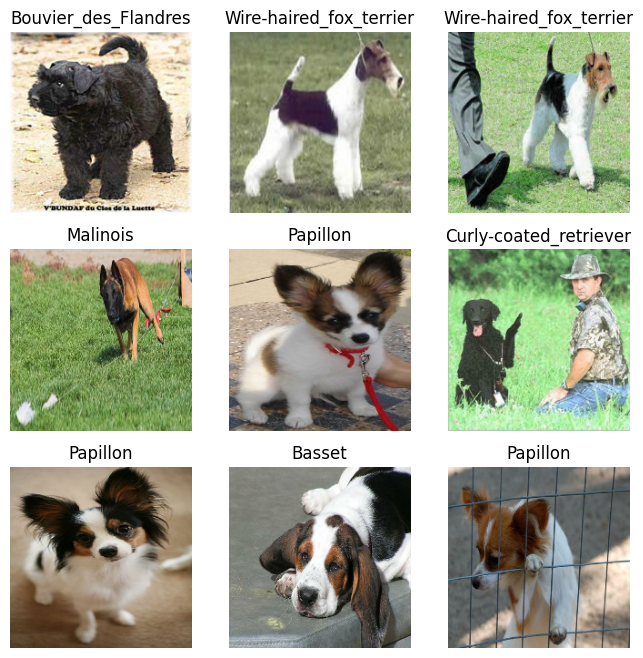

In [ ]:
plt.figure(figsize=(8, 8))
# отображение 9 картинок из батча 1 обучающей выборки
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]])
        plt.axis("off")

In [ ]:
# Аугментация изображений с использованием слоев, определенных в списке
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    """Функция для аугментации изображений:
    - Принимает на вход набор изображений.
    - Каждое изображение последовательно проходит через каждый слой аугментации, где выполняется указанное преобразование.
    - Результат после всех преобразований возвращается."""
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

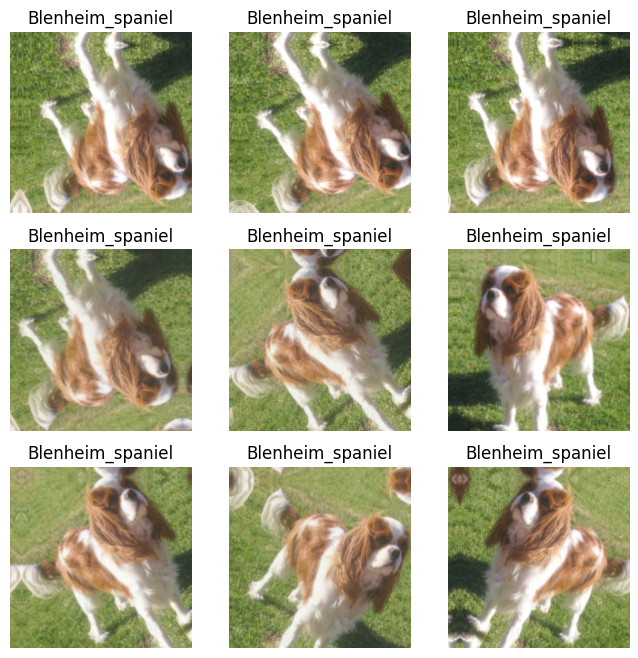

In [ ]:
plt.figure(figsize=(8, 8))

for images, label in train_ds.take(1):
    for i in range(9):
        augmented_images = img_augmentation(images[0]) # применяем аугментацию к первому изображению в батче
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title("{}".format(CLASS_LIST[label[0]]))
        plt.axis("off")

In [ ]:
"""
Процесс подготовки данных для обучения модели, включая:
1. аугментацию изображений для обучающего набора данных
2. одноразрядное кодирование меток для всех наборов (обучающего, валидационного, тестового)
3. оптимизиция загрузки данных для повышения производительности.
"""

train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

test_ds = test_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

In [ ]:
def build_model(num_classes):
    """
    Создает и компилирует глубокую нейронную сеть для задач классификации изображений с использованием предварительно обученной модели EfficientNetV2B0.
    Модель предназначена для дальнейшего обучения на новом наборе данных, с добавлением новых верхних слоев для адаптации к конкретной задаче классификации.
    """
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка весов предварительно обученной модели
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="prediction")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNetV2B0")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
model = build_model(CLASS_COUNT)
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 200, 200, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 200, 200, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 100, 100, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 100, 100, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 100, 100, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 100, 100, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 100, 100, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 100, 100, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 50, 50, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 50, 50, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 50, 50, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 50, 50, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 50, 50, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,937,242 (22.65 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
epochs = 10

# Определяем список коллбэков
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'best_model_pretrain_10_classes.keras',
        monitor = 'val_acc',
        save_best_only = True,
        mode = 'max',
        verbose = 0
    )
]


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - acc: 0.6233 - loss: 1.4546 - val_acc: 0.9793 - val_loss: 0.1110
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - acc: 0.8520 - loss: 0.7630 - val_acc: 0.9752 - val_loss: 0.1159
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - acc: 0.8641 - loss: 0.6117 - val_acc: 0.9669 - val_loss: 0.1466
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - acc: 0.8701 - loss: 0.6125 - val_acc: 0.9752 - val_loss: 0.1580
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - acc: 0.8658 - loss: 0.7842 - val_acc: 0.9752 - val_loss: 0.2168
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - acc: 0.8871 - loss: 0.6231 - val_acc: 0.9711 - val_loss: 0.1488
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - acc: 0.8917 - loss: 0.5410 - val_acc: 0.9504 - val_loss: 0.2585
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - acc: 0.8593 - loss: 0.7071 - val_acc: 0.9628 - val_loss: 0.1790
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - acc: 0.8958 - l

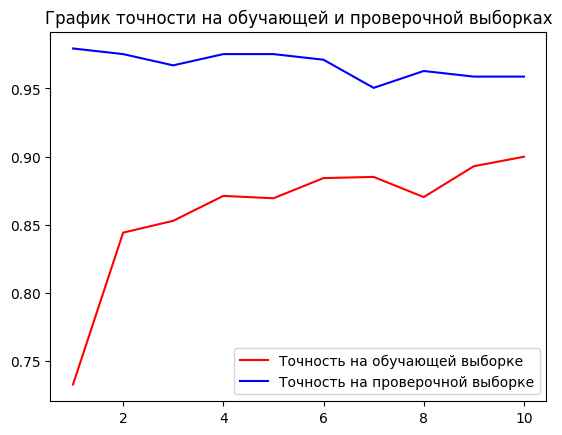

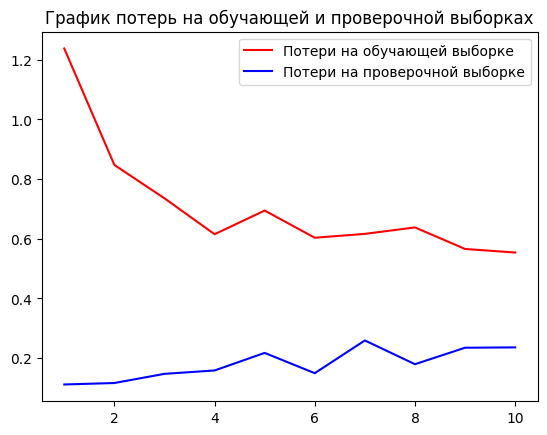

In [ ]:
show_plot(history)

In [ ]:
model.load_weights('best_model_pretrain_10_classes.keras')

In [ ]:
results = model.evaluate(test_ds)
print("test loss, test acc:", results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - acc: 0.9795 - loss: 0.0632
test loss, test acc: [0.0745471939444542, 0.97265625]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


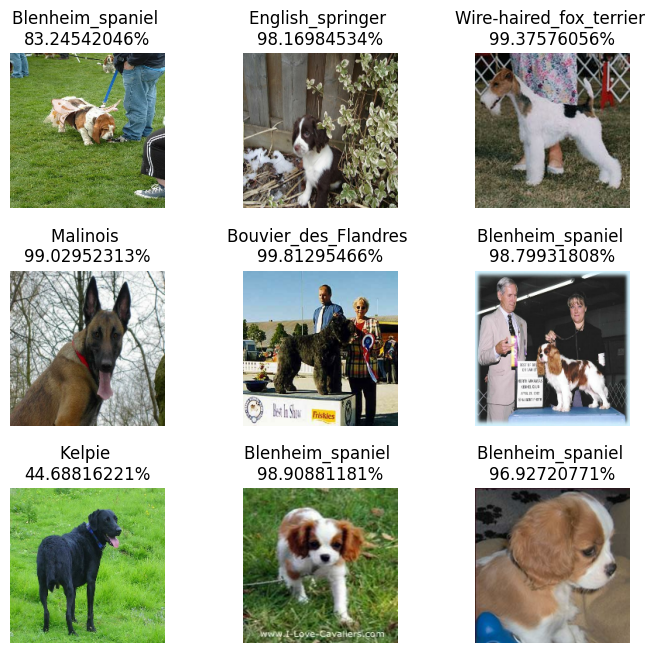

In [ ]:
from numpy import argmax

plt.figure(figsize=(8, 8))

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.axis("off")
        plt.title("{}".format(CLASS_LIST[argmax(predictions[i])]))
        plt.title(f"{CLASS_LIST[argmax(predictions[i])]} \n{(max(predictions[i])*100).round(8)}%")
        plt.axis("off")
        plt.subplots_adjust(wspace=0.5)

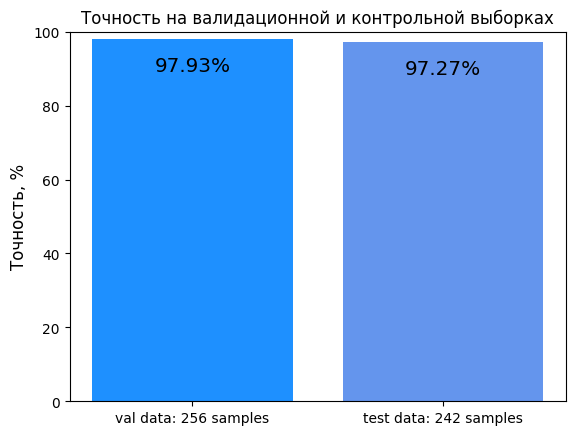

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

top_val_acc = max(history_dict['val_acc'])*100
top_test_acc = results[1]*100
test_data_samples = count_files_in_directory(os.path.join(DATASET_DIR, 'test'))
val_data_samples = count_files_in_directory(os.path.join(DATASET_DIR, 'val'))

bars = plt.bar(
    [f'val data: {test_data_samples} samples', f'test data: {val_data_samples} samples'],
    [top_val_acc, top_test_acc],
    color=['#1E90FF','#6495ED']
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval*0.9 , f'{yval:.2f}%', ha='center', va='bottom', fontsize='x-large')

plt.ylabel('Точность, %', fontsize='large')
plt.ylim(0, 100)
plt.title('Точность на валидационной и контрольной выборках', fontsize='large')
plt.show()


### 120 classes. augmented. val_acc, test_acc 79%

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0

print("keras.__version: ", keras.__version__)

IMAGE_SIZE = (200, 200) # Размер определен выбором модели (от 128 до 300)
BATCH_SIZE = 128

keras.__version:  3.4.1


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-10-23 12:52:05--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  16.4MB/s    in 43s     

2024-10-23 12:52:49 (17.2 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
IMAGE_PATH = './images/'  # создаем переменную для папок с картинками из датасета

!unzip -qo "stanford_dogs" -d ./images/  # unzip в папку

In [ ]:
# Фильтрация битых файлов
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь

    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
# # Выбираем рандомные 10 классов
# from random import sample

# sample_list = sample(os.listdir(IMAGE_PATH), 10)
# print(sample_list)

In [ ]:
# import shutil

# # Удаляем ненужные папки
# # Проходим по всем элементам в IMAGE_PATH
# for folder_name in os.listdir(IMAGE_PATH):
#     folder_path = os.path.join(IMAGE_PATH, folder_name)

#     # Проверяем, является ли элемент каталогом и не включён ли он в sample_list
#     if os.path.isdir(folder_path) and folder_name not in sample_list:
#         # Удаляем каталог
#         shutil.rmtree(folder_path)
#         # print(f"Удалён каталог: {folder_path}")

In [ ]:
DATASET_DIR = './dataset'

In [ ]:
import os
import shutil
import random

# Создаем папки для train, test и val
os.makedirs(os.path.join(DATASET_DIR, 'train'), exist_ok=True)
os.makedirs(os.path.join(DATASET_DIR, 'test'), exist_ok=True)
os.makedirs(os.path.join(DATASET_DIR, 'val'), exist_ok=True)

# Получаем списки классов
classes = os.listdir(IMAGE_PATH)

for class_name in classes:
    class_folder = os.path.join(IMAGE_PATH, class_name)

    if os.path.isdir(class_folder):
        # Получаем список изображений в классе
        images = os.listdir(class_folder)

        # Перемешиваем изображения
        random.shuffle(images)

        # Определяем количество изображений для каждой категории
        total_images = len(images)
        num_train = int(total_images * 0.7)
        num_val = int(total_images * 0.15)

        # Выделяем подмножества для train, val, test
        train_images = images[:num_train]
        val_images = images[num_train:num_train + num_val]
        test_images = images[num_train + num_val:]

        # Создаем папки для классов в train, test и val
        os.makedirs(os.path.join(DATASET_DIR, 'train', class_name), exist_ok=True)
        os.makedirs(os.path.join(DATASET_DIR, 'val', class_name), exist_ok=True)
        os.makedirs(os.path.join(DATASET_DIR, 'test', class_name), exist_ok=True)

        # Копируем изображения в соответствующие папки
        for image in train_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(DATASET_DIR, 'train', class_name, image))

        for image in val_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(DATASET_DIR, 'val', class_name, image))

        for image in test_images:
            shutil.copy(os.path.join(class_folder, image), os.path.join(DATASET_DIR, 'test', class_name, image))


def count_files_in_directory(directory):
    total_files = 0

    # Проходим по всем директориям и поддиректориям
    for dirpath, dirnames, filenames in os.walk(directory):
        total_files += len(filenames)  # Считаем количество файлов в текущем каталоге

    return total_files


print("Датасет успешно организован!")

for folder_name in os.listdir(DATASET_DIR):
    print(f'{folder_name}: {count_files_in_directory(os.path.join(DATASET_DIR, folder_name))} изображений')


Датасет успешно организован!
train: 14349 изображений
val: 3024 изображений
test: 3197 изображений


In [ ]:
# Загружаем обучающую выборку
train_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/train",
    image_size=IMAGE_SIZE,  # Измените размер под ваши требования
    batch_size=32,
    seed=42,
)

# Загружаем валидационную выборку
val_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/val",
    image_size=IMAGE_SIZE,  # Измените размер под ваши требования
    batch_size=32,
    seed=42,
)

# Загружаем тестовую выборку
test_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATASET_DIR}/test",
    image_size=IMAGE_SIZE,  # Измените размер под ваши требования
    batch_size=32,
    seed=42,
)

Found 14349 files belonging to 120 classes.
Found 3024 files belonging to 120 classes.
Found 3197 files belonging to 120 classes.


In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

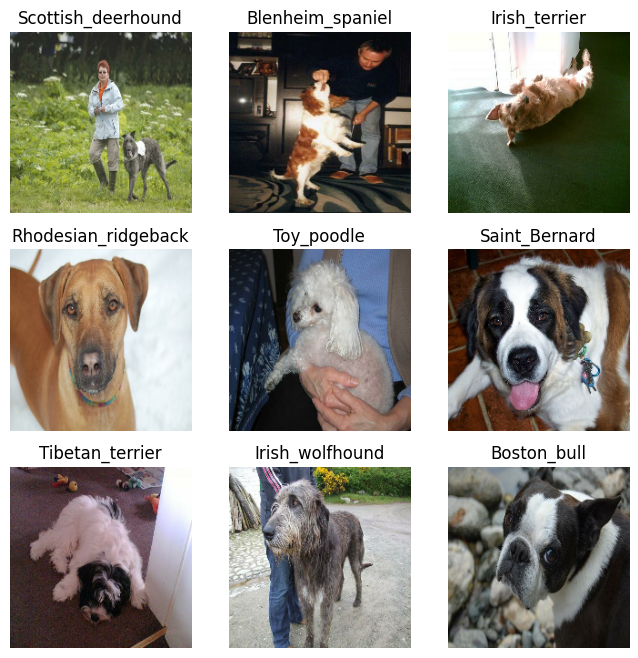

In [ ]:
plt.figure(figsize=(8, 8))
# отображение 9 картинок из батча 1 обучающей выборки
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]])
        plt.axis("off")

In [ ]:
# Аугментация изображений с использованием слоев, определенных в списке
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    """Функция для аугментации изображений:
    - Принимает на вход набор изображений.
    - Каждое изображение последовательно проходит через каждый слой аугментации, где выполняется указанное преобразование.
    - Результат после всех преобразований возвращается."""
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

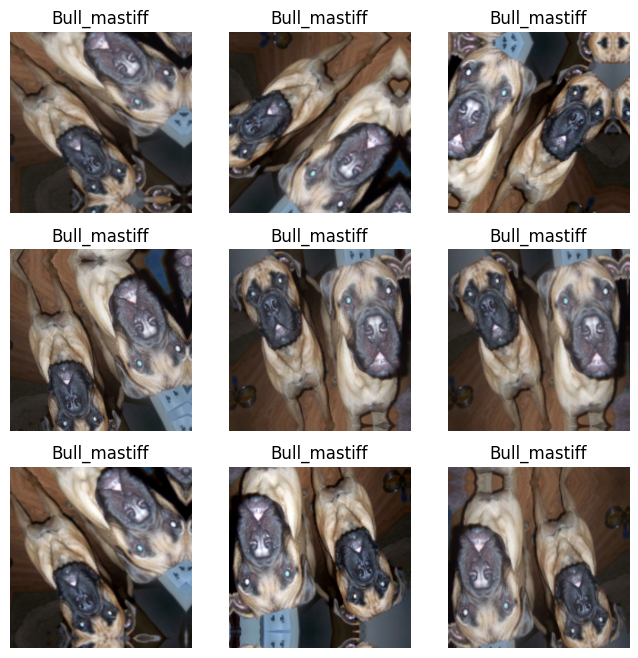

In [ ]:
plt.figure(figsize=(8, 8))

for images, label in train_ds.take(1):
    for i in range(9):
        augmented_images = img_augmentation(images[0]) # применяем аугментацию к первому изображению в батче
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title("{}".format(CLASS_LIST[label[0]]))
        plt.axis("off")

In [ ]:
"""
Процесс подготовки данных для обучения модели, включая:
1. аугментацию изображений для обучающего набора данных
2. одноразрядное кодирование меток для всех наборов (обучающего, валидационного, тестового)
3. оптимизиция загрузки данных для повышения производительности.
"""

train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

test_ds = test_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

In [ ]:
def build_model(num_classes):
    """
    Создает и компилирует глубокую нейронную сеть для задач классификации изображений с использованием предварительно обученной модели EfficientNetV2B0.
    Модель предназначена для дальнейшего обучения на новом наборе данных, с добавлением новых верхних слоев для адаптации к конкретной задаче классификации.
    """
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка весов предварительно обученной модели
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)

    outputs = layers.Dense(num_classes, activation="softmax", name="prediction")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNetV2B0")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
model = build_model(CLASS_COUNT)
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 200, 200, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 200, 200, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 100, 100, 32)   │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 100, 100, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 100, 100, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 100, 100, 16)   │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 100, 100, 16)   │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 100, 100, 16)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, 50, 50, 64)     │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, 50, 50, 64)     │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, 50, 50, 64)     │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, 50, 50, 32)     │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, 50, 50, 32)     │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 6,078,152 (23.19 MB)

 Trainable params: 156,280 (610.47 KB)

 Non-trainable params: 5,921,872 (22.59 MB)

In [ ]:
epochs = 10

# Определяем список коллбэков
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'best_model_pretrain_120_classes.keras',
        monitor = 'val_acc',
        save_best_only = True,
        mode = 'max',
        verbose = 0
    )
]


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 195s 369ms/step - acc: 0.3309 - loss: 4.2850 - val_acc: 0.7781 - val_loss: 0.7322
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 185s 372ms/step - acc: 0.5314 - loss: 1.7801 - val_acc: 0.7933 - val_loss: 0.6805
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 140s 310ms/step - acc: 0.5495 - loss: 1.6976 - val_acc: 0.7811 - val_loss: 0.6870
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 311ms/step - acc: 0.5474 - loss: 1.7116 - val_acc: 0.7930 - val_loss: 0.6640
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 309ms/step - acc: 0.5538 - loss: 1.6726 - val_acc: 0.7851 - val_loss: 0.6795
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 324ms/step - acc: 0.5531 - loss: 1.6819 - val_acc: 0.7890 - val_loss: 0.6628
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 204s 330ms/step - acc: 0.5484 - loss: 1.6733 - val_acc: 0.7917 - val_loss: 0.6935
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 329ms/step - acc: 0.5634 - loss: 1.7115 - val_acc: 0.7738 - val_loss: 0.7787
Epoch 9/10
449/449 ━━━━━

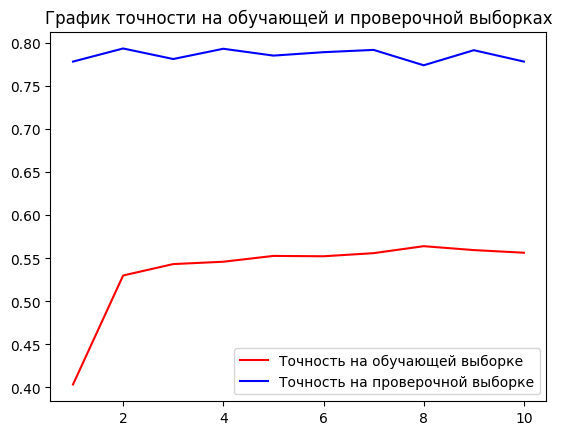

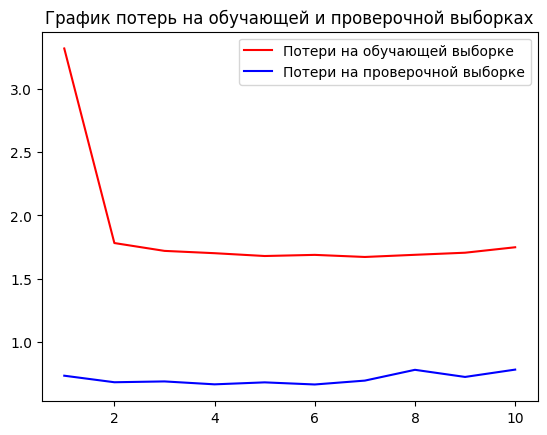

In [ ]:
show_plot(history)

In [ ]:
model.load_weights('best_model_pretrain_120_classes.keras')

In [ ]:
results = model.evaluate(test_ds)
print("test loss, test acc:", results)

100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - acc: 0.7916 - loss: 0.6693
test loss, test acc: [0.6797952651977539, 0.7882390022277832]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


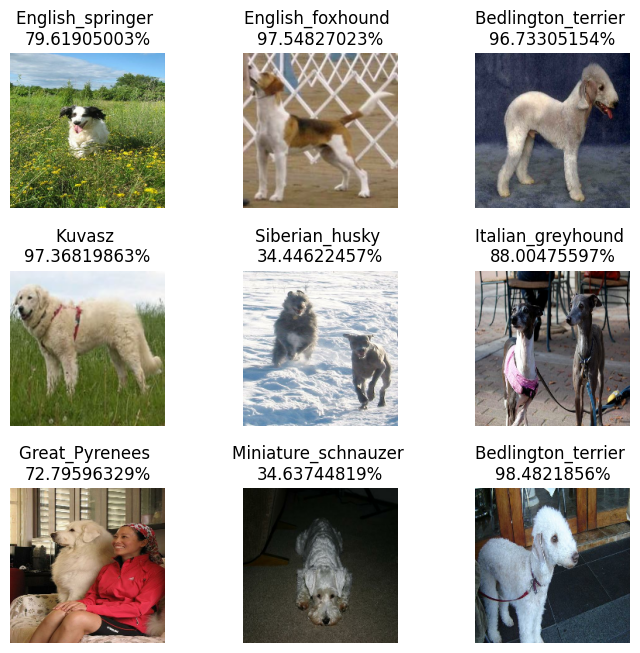

In [ ]:
from numpy import argmax

plt.figure(figsize=(8, 8))

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.axis("off")
        plt.title("{}".format(CLASS_LIST[argmax(predictions[i])]))
        plt.title(f"{CLASS_LIST[argmax(predictions[i])]} \n{(max(predictions[i])*100).round(8)}%")
        plt.axis("off")
        plt.subplots_adjust(wspace=0.5)

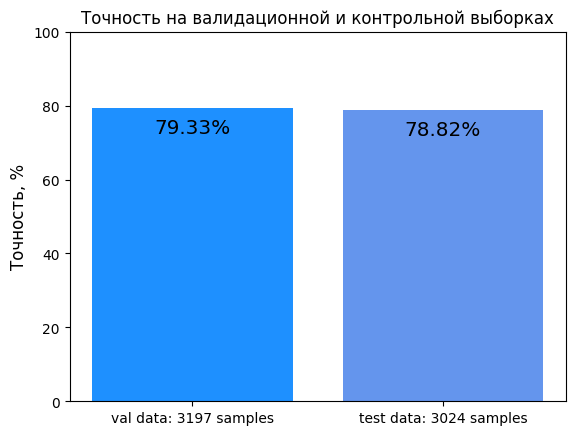

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

top_val_acc = max(history_dict['val_acc'])*100
top_test_acc = results[1]*100
test_data_samples = count_files_in_directory(os.path.join(DATASET_DIR, 'test'))
val_data_samples = count_files_in_directory(os.path.join(DATASET_DIR, 'val'))

bars = plt.bar(
    [f'val data: {test_data_samples} samples', f'test data: {val_data_samples} samples'],
    [top_val_acc, top_test_acc],
    color=['#1E90FF','#6495ED']
)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval*0.9 , f'{yval:.2f}%', ha='center', va='bottom', fontsize='x-large')

plt.ylabel('Точность, %', fontsize='large')
plt.ylim(0, 100)
plt.title('Точность на валидационной и контрольной выборках', fontsize='large')
plt.show()
